In [116]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer

import seaborn as sns
sns.set(rc={'figure.figsize':(6,6)}) 
import warnings
warnings.simplefilter("ignore")

%matplotlib inline

# Cleaning the Two Year Data

In [117]:
df = pd.read_csv("data/compas-scores-two-years.csv")

In [118]:
#drop unecessary columns
drop_columns = ['compas_screening_date', 'juv_fel_count',
                'juv_misd_count','c_case_number','vr_charge_degree',
                'vr_offense_date','vr_charge_desc','c_arrest_date',
                'r_case_number', 'vr_case_number','start',
                'juv_other_count','days_b_screening_arrest','c_days_from_compas',
                'first','last','name','dob','c_jail_in','c_jail_out','c_offense_date',
                'c_charge_degree','c_charge_desc','r_charge_degree','r_days_from_arrest',
                'r_offense_date','r_charge_desc','r_jail_in','r_jail_out','violent_recid',
                'score_text','screening_date','v_score_text','v_screening_date','in_custody',
                'out_custody','id','age_cat','is_recid','is_violent_recid','decile_score.1',
                'priors_count.1','end','event','type_of_assessment','v_type_of_assessment','race']
df = df.drop(drop_columns,axis=1)

In [119]:
df.head()

,sex,age,decile_score,priors_count,v_decile_score,two_year_recid
0,Male,69,1,0,1,0
1,Male,34,3,0,1,1
2,Male,24,4,4,3,1
3,Male,23,8,1,6,0
4,Male,43,1,2,1,0


In [121]:
#separate df into numerical and categorical
numerical_data = df.select_dtypes(np.number)
categorical_data = df.select_dtypes([object, "category"])

In [122]:
#normalize the numerical data
numerical_data_normalized = MinMaxScaler().fit_transform(numerical_data) # this line scales our data

numerical_data_normalized = pd.DataFrame(              #this pops it back in data frame format 
                    numerical_data_normalized,
                    columns=numerical_data.columns) 

numerical_data_normalized.head()

,age,decile_score,priors_count,v_decile_score,two_year_recid
0,0.653846,0.000000,0.000000,0.000000,0.0
1,0.205128,0.222222,0.000000,0.000000,1.0
2,0.076923,0.333333,0.105263,0.222222,1.0
3,0.064103,0.777778,0.026316,0.555556,0.0
4,0.320513,0.000000,0.052632,0.000000,0.0


In [123]:
#codify the categorical data so that it may be used in the model
categorical_data_codified = pd.get_dummies(
                                    categorical_data,
                                    dtype="int64",
                                    drop_first = True
).reset_index() #have to reset the index to be able to concat

In [124]:
#combine both datasets
df_clean = pd.concat([numerical_data_normalized, categorical_data_codified], axis=1)
df_clean.head()

,age,decile_score,priors_count,v_decile_score,two_year_recid,index,sex_Male
0,0.653846,0.000000,0.000000,0.000000,0.0,0,1
1,0.205128,0.222222,0.000000,0.000000,1.0,1,1
2,0.076923,0.333333,0.105263,0.222222,1.0,2,1
3,0.064103,0.777778,0.026316,0.555556,0.0,3,1
4,0.320513,0.000000,0.052632,0.000000,0.0,4,1


# K-means begins

### Deciding how many clusters to use using the elbow method to compare inertias

In [125]:
#Creating a function that takes in a range of values for K (or how many clusters)
# runs the model and then outputs the inertia value so we can see how well the clusters are grouped
def evaluate_k_kmeans_inertia(k):
    print(f"running Kmeans with k={k}")
    estimator_kmeans = KMeans(random_state=42, n_clusters=k)
    estimator_kmeans.fit(df_clean)
    return estimator_kmeans.inertia_

In [126]:
range_k = [2, 3, 4, 5, 8, 10, 15, 20, 25, 30]
results_k = {}
for k in range_k:
    results_k[k] = evaluate_k_kmeans_inertia(k)

running Kmeans with k=2
running Kmeans with k=3
running Kmeans with k=4
running Kmeans with k=5
running Kmeans with k=8
running Kmeans with k=10
running Kmeans with k=15
running Kmeans with k=20
running Kmeans with k=25
running Kmeans with k=30


In [127]:
results_k

{2: 7821475585.758453,
 3: 3476222749.220322,
 4: 1955497134.8336782,
 5: 1251455358.0005527,
 8: 488940969.2726024,
 10: 312915686.2705364,
 15: 139090648.3915456,
 20: 78261635.47106008,
 25: 50108593.889249094,
 30: 34872122.75772133}

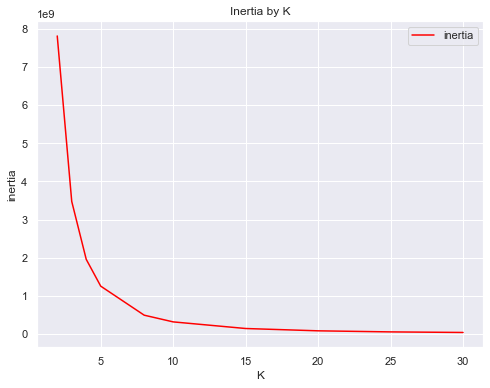

In [128]:
#plot the data to see the inflection point
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.lineplot(
    [c[0] for c in results_k.items()],
    [c[1] for c in results_k.items()], label="inertia", color="red")
ax.set_xlabel("K")
ax.set_ylabel("inertia")
ax.set_title("Inertia by K")
ax.legend()

The elbow point is about 8, so the number of clusters we will use is 8.

### Fitting and Predicting, and adding clusters to original df

In [129]:
#set the model to kmeans
estimator_kmeans = KMeans(random_state=42, n_clusters=8)

In [130]:
#fitting the model
estimator_kmeans.fit(df_clean)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [131]:
#making predictions/clusters
estimator_kmeans.predict(df_clean)

array([3, 3, 3, ..., 1, 1, 1])

In [132]:
#adding the clusters to the original dataframe
df["cluster_id"] = estimator_kmeans.labels_
df.head()

,sex,age,decile_score,priors_count,v_decile_score,two_year_recid,cluster_id
0,Male,69,1,0,1,0,3
1,Male,34,3,0,1,1,3
2,Male,24,4,4,3,1,3
3,Male,23,8,1,6,0,3
4,Male,43,1,2,1,0,3


### Analysis of Clusters

In [133]:
#look at the amount of each cluster to make sure the clusters are balanced
df.cluster_id.value_counts()

1    915
6    910
2    905
7    899
3    898
4    897
5    895
0    895
Name: cluster_id, dtype: int64

In [136]:
def kmeans_cluster(df, n_clusters=2):
    """This function assigns clusters to every row in the dataframe via kmeans"""
    model = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = model.fit_predict(df)
    cluster_results = df.copy()
    cluster_results['Cluster'] = clusters
    return cluster_results

def graph_summary_clustering(results):
    """this function produces a summary of the clusters"""
    cluster_size = results.groupby(['Cluster']).size().reset_index()
    cluster_size.columns = ['Cluster', 'Count']
    cluster_means = results.groupby(['Cluster'], as_index=False).mean()
    cluster_summary = pd.merge(cluster_size, cluster_means, on='Cluster')
    cluster_summary = cluster_summary.drop(["Count", "index"], axis=1).set_index("Cluster")
    return cluster_summary[sorted(cluster_summary.columns)]

In [137]:
cluster_results = kmeans_cluster(df_clean, 8)
cluster_summary = graph_summary_clustering(cluster_results);

Produces a summary in which for numerical variables we get an idea of which clusters have higher values and for categorical variables, we get the percentage of each cluster that belongs to each one of the different values per categorical column.

In [138]:
cluster_summary

,age,decile_score,priors_count,sex_Male,two_year_recid,v_decile_score
Cluster,,,,,,
0,0.223192,0.380881,0.091914,0.843575,0.441341,0.290379
1,0.212148,0.387371,0.092062,0.792350,0.469945,0.300546
2,0.213288,0.394352,0.087031,0.815470,0.471823,0.303254
3,0.212952,0.398045,0.094039,0.809577,0.444321,0.311804
4,0.219650,0.375201,0.086898,0.800446,0.414716,0.283414
5,0.212577,0.410552,0.096354,0.814525,0.481564,0.319926
6,0.209721,0.396581,0.092828,0.795604,0.432967,0.302564
7,0.221571,0.376591,0.089924,0.781980,0.448276,0.280806


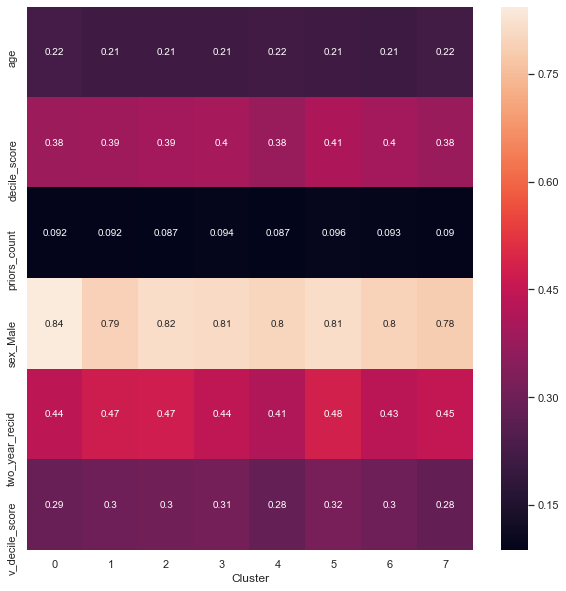

In [139]:
#summary in the form of a heatmap
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cluster_summary.transpose(), annot=True);

# Conclusion: no concrete natural clusters in this data as all clusters are more of less the same